In [34]:
#Here I play with the sample from attention documentaion # https://github.com/philipperemy/keras-attention-mechanism
#I visualized the last step and just add more debugging to sample


import os
import sys

import matplotlib.pyplot as plt
import numpy
import numpy as np
from keract import get_activations
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM

from attention import Attention  




In [35]:
#!pip install keract
#!pip install attention

In [3]:

def add_numbers_before_delimiter(n: int, seq_length: int, delimiter: float = 0.0,
                                         index_1: int = None) -> (np.array, np.array):
    """
    Task: Add all the numbers that come before the delimiter.
    x = [1, 2, 3, 0, 4, 5, 6, 7, 8, 9]. Result is y =  6.
    @param n: number of samples in (x, y).
    @param seq_length: length of the sequence of x.
    @param delimiter: value of the delimiter. Default is 0.0
    @param index_1: index of the number that comes after the first 0.
    @return: returns two numpy.array x and y of shape (n, seq_length, 1) and (n, 1).
    """
    x = np.random.uniform(0, 1, (n, seq_length))
    y = np.zeros(shape=(n, 1))
    for i in range(len(x)):
        if index_1 is None:
            a = np.random.choice(range(1, len(x[i])), size=1, replace=False)
        else:
            a = index_1
        #print(type(a))    
        aint = a
        if isinstance(a,numpy.ndarray):          
          aint = a[0]
        y[i] =  np.sum(x[i, 0:aint])
        x[i, aint] = delimiter

    x = np.expand_dims(x, axis=-1)
    return x, y

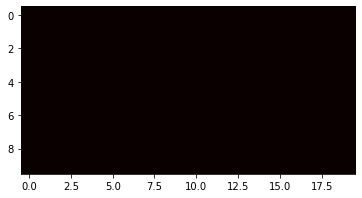

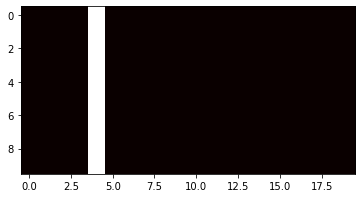

In [63]:
numpy.random.seed(7)

# data. definition of the problem.
seq_length = 20
x_train, y_train = add_numbers_before_delimiter(20_000, seq_length)
x_val, y_val = add_numbers_before_delimiter(4_000, seq_length)

# just arbitrary values. it's for visual purposes. easy to see than random values.
test_index_1 = 4
x_test, _ = add_numbers_before_delimiter(10, seq_length, 0, test_index_1)
# x_test_mask is just a mask that, if applied to x_test, would still contain the information to solve the problem.
# we expect the attention map to look like this mask.
x_test_mask = np.zeros_like(x_test[..., 0])
plt.imshow(x_test_mask, cmap='hot')
plt.show()
x_test_mask[:, test_index_1:test_index_1 + 1] = 1
plt.imshow(x_test_mask, cmap='hot')

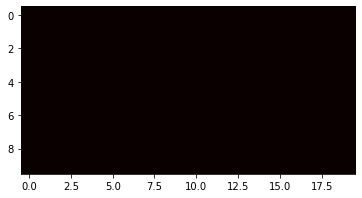

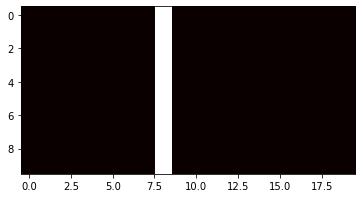

In [66]:
#i want to create  a second dataset 
test_index_1 = 8
x_test6, _ = add_numbers_before_delimiter(10, seq_length, 0, test_index_1)

x_test_mask6 = np.zeros_like(x_test6[..., 0])
plt.imshow(x_test_mask6, cmap='hot')
plt.show()
x_test_mask6[:, test_index_1:test_index_1 + 1] = 1
plt.imshow(x_test_mask6, cmap='hot')

In [68]:
print(x_test6.shape)
print(x_test.shape)
#combine the former map with current
x_test_combined = np.concatenate([x_test,x_test6])
x_test_mask_combined = np.concatenate([x_test_mask,x_test_mask6])

print(x_test_combined.shape)
print(x_test_mask_combined.shape)

(10, 20, 1)
(10, 20, 1)
(20, 20, 1)
(20, 20)


In [69]:
#below is mostly from documentation , I changed the attention saving part

model = Sequential([
    LSTM(100, input_shape=(seq_length, 1), return_sequences=True),
    Attention(name='attention_weight'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer='adam')
print(model.summary())

output_dir = 'task_add_two_numbers'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

max_epoch =  100

attentions_saved = []
attentions_maps_saved = []
attentions_combined_saved = []
class VisualiseAttentionMap(Callback):
  def on_epoch_end(self, epoch, logs=None):
    #try and save the test attentions
    
    attention_map = get_activations(model, x_test, layer_names='attention_weight')['attention_weight']
    attention_map_combined = get_activations(model, x_test_combined, layer_names='attention_weight')['attention_weight']

    attentions_saved.append(np.concatenate([attention_map, x_test_mask]))
    attentions_combined_saved.append(np.concatenate([attention_map_combined, x_test_mask_combined]))
    attentions_maps_saved.append( attention_map)

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=max_epoch,
              batch_size=64, callbacks=[VisualiseAttentionMap()])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 100)           40800     
_________________________________________________________________
attention_score_vec (Dense)  (None, 20, 100)           10000     
_________________________________________________________________
last_hidden_state (Lambda)   (None, 100)               0         
_________________________________________________________________
attention_score (Dot)        (None, 20)                0         
_________________________________________________________________
attention_weight (Activation (None, 20)                0         
_________________________________________________________________
context_vector (Dot)         (None, 100)               0         
_________________________________________________________________
attention_output (Concatenat (None, 200)              

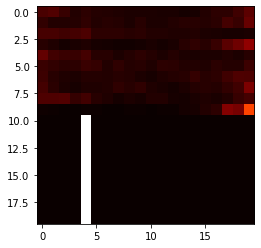

In [71]:
#here model only tries for index 4
plt.imshow(attentions_saved[0], cmap='hot')

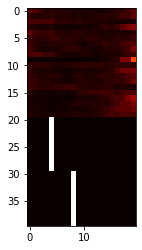

In [78]:
#here model  tries both index 4 and 8
plt.imshow(attentions_combined_saved[0], cmap='hot')

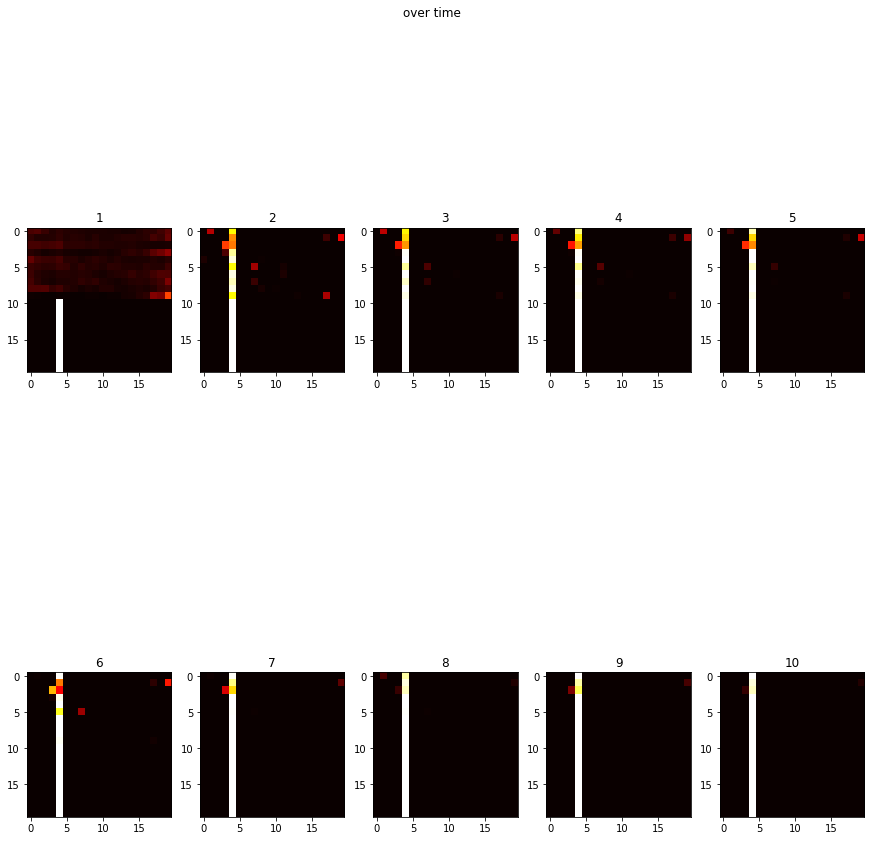

In [77]:
fig, axs = plt.subplots(2,5 ,figsize=(15,15))
fig.suptitle('over time')

for i in range(10):
  col = i % 5
  row = i // 5
  axs[row][col].set_title(str(i+1))
  axs[row][col].imshow(attentions_saved[i * 10], cmap='hot')


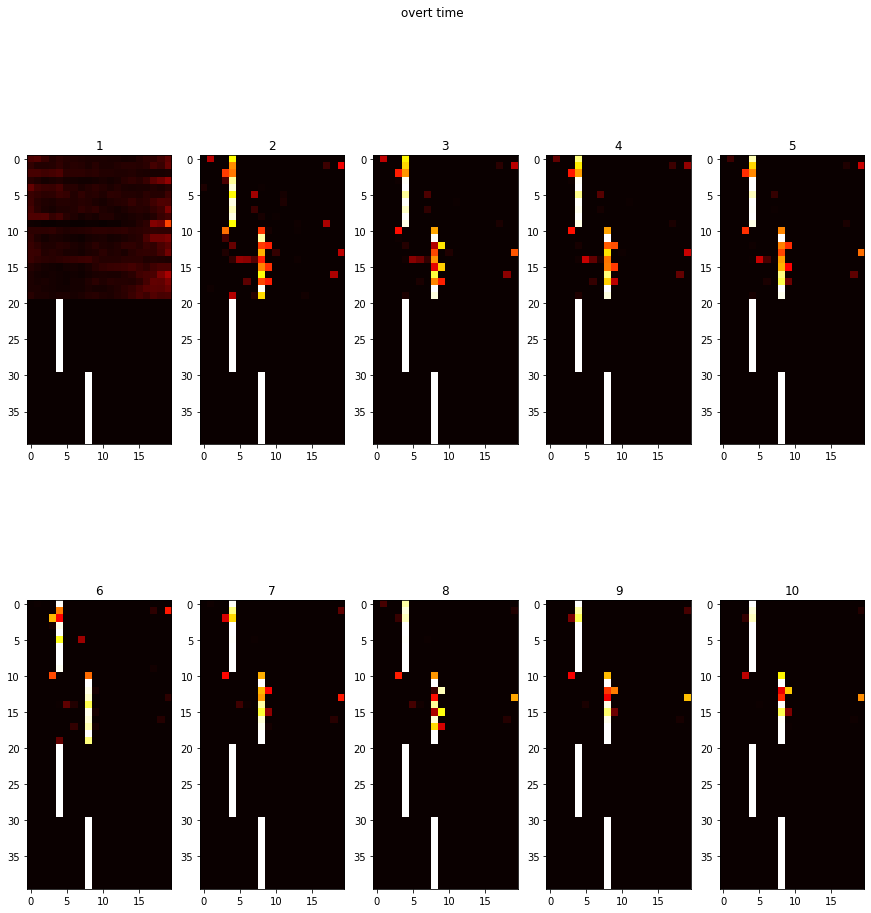

In [74]:
fig, axs = plt.subplots(2,5 ,figsize=(15,15))
fig.suptitle('overt time')

for i in range(10):
  col = i % 5
  row = i // 5
  axs[row][col].set_title(str(i+1))
  axs[row][col].imshow(attentions_combined_saved[i * 10], cmap='hot')


In [79]:
#we dont have to run the model for getting activation
attention_map = get_activations(model, x_test, layer_names='attention_weight')['attention_weight']

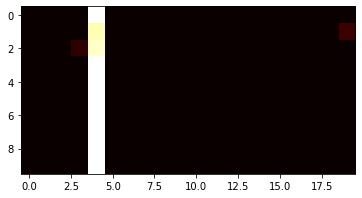

In [82]:
plt.imshow(attention_map, cmap='hot')

In [81]:
attention_map

array([[4.1294223e-17, 6.5780251e-04, 7.7747651e-36, 0.0000000e+00,
        9.9934214e-01, 4.3816782e-35, 1.5388568e-38, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.6926095e-27,
        8.6537179e-35, 0.0000000e+00, 4.9187329e-36, 5.1420835e-35],
       [6.4656968e-21, 0.0000000e+00, 7.6354236e-34, 1.3868036e-22,
        9.2205316e-01, 1.2193782e-34, 4.6983264e-19, 5.1269241e-34,
        0.0000000e+00, 2.7587830e-18, 0.0000000e+00, 0.0000000e+00,
        1.4485539e-29, 1.7219751e-34, 2.4040100e-37, 0.0000000e+00,
        1.2336606e-37, 9.9929013e-05, 1.2037189e-36, 7.7846892e-02],
       [3.5761294e-17, 1.5293287e-23, 3.0160275e-30, 5.7193048e-02,
        9.4280696e-01, 1.4547188e-34, 4.3348061e-29, 4.7931022e-31,
        3.8941413e-35, 1.7424937e-25, 1.7932747e-37, 1.3523163e-33,
        8.5028540e-37, 1.0837970e-34, 1.6436494e-23, 0.0000000e+00,
        2.7352612e-38, 0.0000000e+00, 0.000000